## Import the libs

In [2]:
import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import io

Instructions for updating:
non-resource variables are not supported in the long term


## Import and read the data

In [3]:
data_path = "./data/amazon_data.csv"
data = pd.read_csv(data_path)
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,4.075000,4.478125,3.952344,4.468750,4.468750,322352000
1,2000-01-04,4.268750,4.575000,4.087500,4.096875,4.096875,349748000
2,2000-01-05,3.525000,3.756250,3.400000,3.487500,3.487500,769148000
3,2000-01-06,3.565625,3.634375,3.200000,3.278125,3.278125,375040000
4,2000-01-07,3.350000,3.525000,3.309375,3.478125,3.478125,210108000
...,...,...,...,...,...,...,...
6032,2023-12-22,153.770004,154.350006,152.710007,153.419998,153.419998,29480100
6033,2023-12-26,153.559998,153.979996,153.029999,153.410004,153.410004,25067200
6034,2023-12-27,153.559998,154.779999,153.119995,153.339996,153.339996,31434700
6035,2023-12-28,153.720001,154.080002,152.949997,153.380005,153.380005,27057000


In [4]:
close_data = data['Adj Close'].values
close_data

array([  4.46875   ,   4.09687519,   3.48749995, ..., 153.33999634,
       153.38000488, 151.94000244])

## Processing data

In [5]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(close_data.reshape(-1, 1))

### Plotting

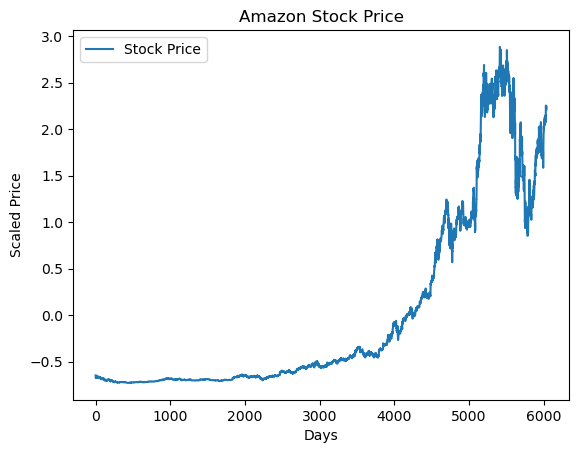

In [6]:
plt.figure(edgecolor='blue')
plt.title('Amazon Stock Price')
plt.xlabel('Days')
plt.ylabel('Scaled Price')
plt.plot(scaled_data, label='Stock Price')
plt.legend()
plt.savefig('./figs/stock_price.png')
plt.show()



## Train, test and CV data

In [7]:
def window_size(data, size):
    X = []
    y = []
    i = 0

    while (i + size) <= len(data) - 1:
        X.append(data[i:i+size])
        y.append(data[i+size])
        i += 1
    
    assert len(X) == len(y)
    
    return X, y

X, y = window_size(scaled_data, 7)

In [8]:
data_size = len(X)

X_train = np.array(X[:int(data_size * 0.80)])
y_train = np.array(y[:int(data_size * 0.80)])

X_test = np.array(X[int(data_size * 0.80):])
y_test = np.array(y[int(data_size * 0.80):])

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4824, 7, 1) (4824, 1)
(1206, 7, 1) (1206, 1)


## Hyperparameters

In [9]:
batch_size = 7
window_size = 7
hidden_layer = 256
clip_margin = 4
learning_rate = 0.001
epochs = 200

In [10]:
### placeholders (X and y) ###
inputs = tf.placeholder(tf.float32, [batch_size, window_size, 1])
targets = tf.placeholder(tf.float32, [batch_size, 1])

## Gates

### Input gate

In [11]:
weights_input_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_input_gate_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_input = tf.Variable(tf.zeros([hidden_layer]))

### forget gate

In [12]:
weights_forget_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_forget_gate_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_forget = tf.Variable(tf.zeros([hidden_layer]))

### output gate

In [13]:
weights_output_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_output_gate_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_output = tf.Variable(tf.zeros([hidden_layer]))

### memory cell

In [14]:
weights_memory_cell = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_memory_cell_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_memory_cell = tf.Variable(tf.zeros([hidden_layer]))

### output layer

In [15]:
weights_output = tf.Variable(tf.truncated_normal([hidden_layer, 1], stddev=0.05))
bias_output_layer = tf.Variable(tf.zeros([1]))

### compute gate states

In [16]:
def lstm_cell(input, output, state):
    input_gate = tf.sigmoid(tf.matmul(input, weights_input_gate) + tf.matmul(output, weights_input_gate_hidden) + bias_input)
    forget_gate = tf.sigmoid(tf.matmul(input, weights_forget_gate) + tf.matmul(output, weights_forget_gate_hidden) + bias_forget)
    output_gate = tf.sigmoid(tf.matmul(input, weights_output_gate) + tf.matmul(output, weights_output_gate_hidden) + bias_output)
    memory_cell = tf.tanh(tf.matmul(input, weights_memory_cell) + tf.matmul(output, weights_memory_cell_hidden) + bias_memory_cell)
    state = state * forget_gate + input_gate * memory_cell
    output = output_gate * tf.tanh(state)

    return state, output

## network loop

In [17]:
output = []

for i in range(batch_size):
    batch_state = np.zeros([1, hidden_layer], dtype=np.float32)
    batch_output = np.zeros([1, hidden_layer], dtype=np.float32)

    for ii in range(window_size):
        batch_state, batch_output = lstm_cell(tf.reshape(inputs[i][ii], (-1, 1)), batch_output, batch_state)

    output.append(tf.matmul(batch_output, weights_output) + bias_output_layer)

output

[<tf.Tensor 'add_63:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_127:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_191:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_255:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_319:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_383:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_447:0' shape=(1, 1) dtype=float32>]

## loss function

In [18]:
losses = []

for i in range(len(output)):
    losses.append(tf.losses.mean_squared_error(tf.reshape(targets[i], (-1, 1)), output[i]))

loss = tf.reduce_mean(losses)

## training

In [19]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)  # Define the optimizer

session = tf.Session()
session.run(tf.global_variables_initializer())

for i in range(epochs):

    traind_scores = []
    ii = 0
    epoch_loss = []

    while(ii + batch_size) <= len(X_train):
        X_batch = X_train[ii:ii+batch_size]
        y_batch = y_train[ii:ii+batch_size]

        o, c, _ = session.run([output, loss, optimizer], feed_dict={inputs:X_batch, targets:y_batch})
        epoch_loss.append(c)
        traind_scores.append(o)
        ii += batch_size

    if (i % 10) == 0:
        print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))

Epoch 0/200  Current loss: 0.005511484574526548
Epoch 10/200  Current loss: 0.0004043113731313497
Epoch 20/200  Current loss: 0.001040398608893156
Epoch 30/200  Current loss: 0.0006992050330154598
Epoch 40/200  Current loss: 0.0006565146031789482


KeyboardInterrupt: 

In [ ]:
traind_scores

[[array([[-0.64701515]], dtype=float32),
  array([[-0.64991075]], dtype=float32),
  array([[-0.64776105]], dtype=float32),
  array([[-0.64964956]], dtype=float32),
  array([[-0.6493383]], dtype=float32),
  array([[-0.6470925]], dtype=float32),
  array([[-0.6491464]], dtype=float32)],
 [array([[-0.65441954]], dtype=float32),
  array([[-0.6470823]], dtype=float32),
  array([[-0.6485218]], dtype=float32),
  array([[-0.65191805]], dtype=float32),
  array([[-0.64990735]], dtype=float32),
  array([[-0.6552702]], dtype=float32),
  array([[-0.65190494]], dtype=float32)],
 [array([[-0.6565872]], dtype=float32),
  array([[-0.6545232]], dtype=float32),
  array([[-0.64052624]], dtype=float32),
  array([[-0.6471364]], dtype=float32),
  array([[-0.64875525]], dtype=float32),
  array([[-0.6418559]], dtype=float32),
  array([[-0.64517635]], dtype=float32)],
 [array([[-0.6563097]], dtype=float32),
  array([[-0.6563984]], dtype=float32),
  array([[-0.65838385]], dtype=float32),
  array([[-0.65872025]], 

## plotting the predictions

In [1]:
flat_scores = [score.item() for sublist in traind_scores for score in sublist]

split_ratio = 0.8
split_index = int(len(flat_scores) * split_ratio)

total_results = flat_scores

train_results = total_results[:split_index]
test_results = total_results
print(split_index)
print(len(test_results))
print(len(test_results[3858:]))
# test_results = flat_scores[split_index:split_index+len(test_results)]
test_results = flat_scores[split_index:]

# train_results_full = np.full(len(scaled_data), np.nan)

sup = np.concatenate([train_results, [0] * len(test_results)])
test_results_full = np.concatenate([[0] * len(train_results), test_results])

NameError: name 'traind_scores' is not defined

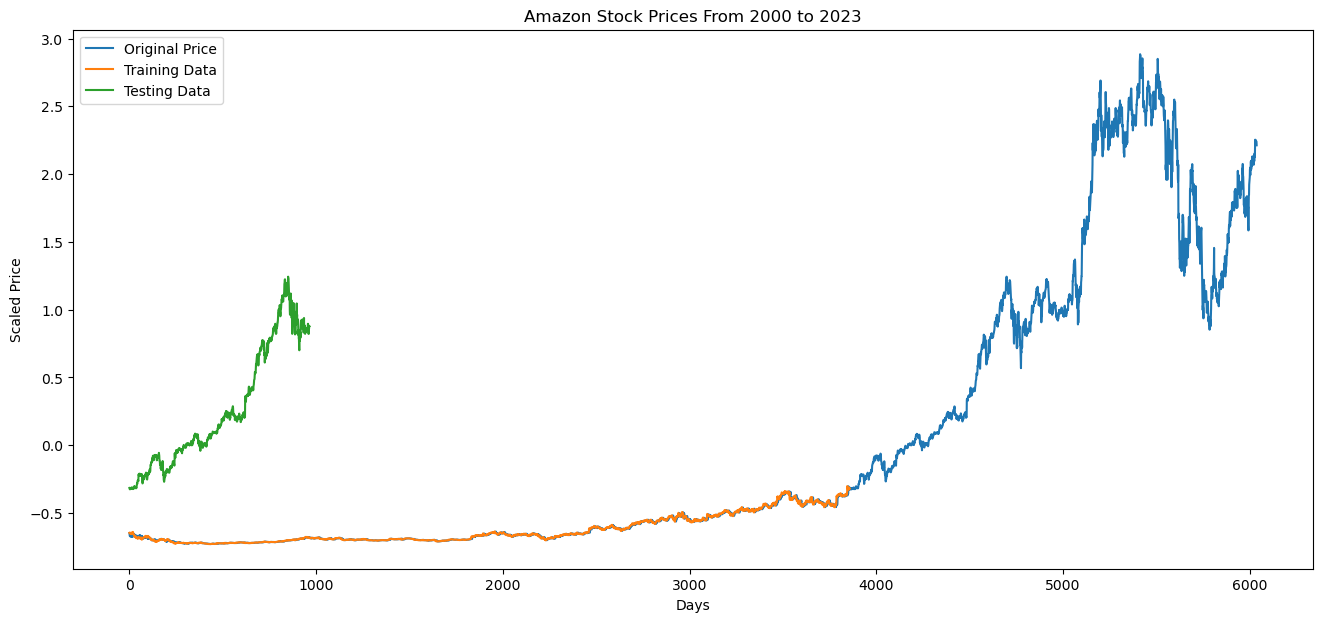

In [52]:
plt.figure(figsize=(16, 7))
plt.title('Amazon Stock Prices From 2000 to 2023')
plt.xlabel('Days')
plt.ylabel('Scaled Price')
plt.plot(scaled_data, label='Original Price')
plt.plot(train_results, label='Training Data')
plt.plot(test_results, label='Testing Data')
plt.legend()
plt.savefig('./figs/stock_prices.png')
plt.show()